(1e-05, 0.1128077759806978)

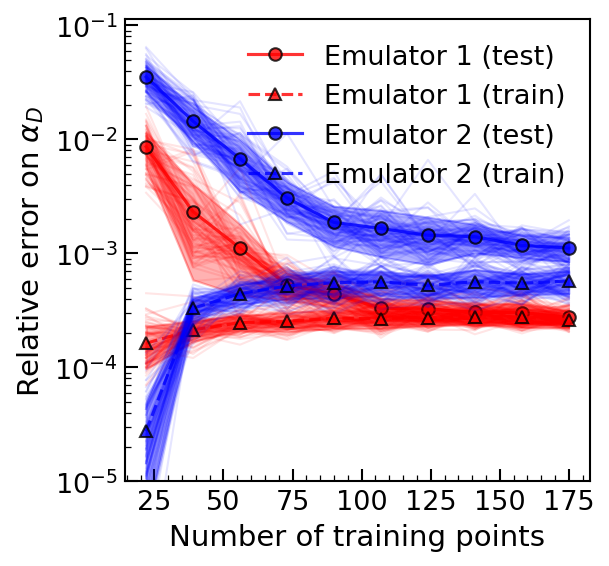

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

# Training sizes (per tier)
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
tiers = range(1, 11)
seeds = [123+i for i in range(100)]





mpl.rcParams.update({
    # Ticks pointing inward on both axes
    "xtick.direction": "in",
    "ytick.direction": "in",


    # Make minor ticks visible too
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,

    # Tick lengths/widths (optional, tweak as you like)
    "xtick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.major.size": 6,
    "ytick.minor.size": 3,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,

    # Increase tick-label font size
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,

    # (Nice to have) larger axis labels/titles globally
    "axes.labelsize": 14,
    "axes.titlesize": 14,
})







def emulator_stats_and_curves(em_tag, color, label, sets, lsl, marker ):
    """
    Load all seeds for an emulator, return mean and std across seeds.
    Also plot the individual seed curves in light gray.
    """
    per_seed_means = []
    for seed in seeds:
        seed_means = []
        for i in tiers:
            df = pd.read_csv(f"../dipoles_exp_param/alphaD_eval_{em_tag}_{seed}/alphaD_relerr_{sets}_tier{i}.csv")
            seed_means.append(df["rel_abs"].to_numpy().mean())
        per_seed_means.append(seed_means)
        # plot this seed in light gray
        plt.plot(n, seed_means, '-', color=color, linewidth=1, alpha=0.1)

    per_seed_means = np.asarray(per_seed_means)  # shape (4, 10)
    mean = per_seed_means.mean(axis=0)
    std  = per_seed_means.std(axis=0)
    
    # plot mean + band
    plt.plot(n, mean, marker = marker, color=color, label=f'{label}', ls = lsl, mec = 'black', alpha = 0.8)
    plt.fill_between(n, mean - std, mean + std, color=color, alpha=0.3)
    
    return mean, std

# ---- Plot ----
plt.figure(figsize=(4,4), dpi = 150)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))

# Em1 (blue)
em1_mean, em1_std = emulator_stats_and_curves("Em1", color="red", label="Emulator 1 (test)", sets="test", lsl = '-',
                                             marker = 'o')

# Em2 (orange)
em2_mean, em2_std = emulator_stats_and_curves("Em1", color="red", label="Emulator 1 (train)", sets="train", lsl = '--',
                                             marker = '^')


#Em1 (blue)
em1_mean, em1_std = emulator_stats_and_curves("Em2", color="blue", label="Emulator 2 (test)", sets="test", 
                                              lsl = '-', marker = 'o')

# Em2 (orange)
em2_mean, em2_std = emulator_stats_and_curves("Em2", color="blue", label="Emulator 2 (train)", sets="train", lsl = '--',
                                             marker = '^')




plt.yscale('log')
plt.ylabel(r'Relative error on $\alpha_D$')
plt.xlabel('Number of training points')
plt.legend(frameon=False)
plt.ylim(1e-5)


#plt.savefig('NumberOfTrain.pdf', bbox_inches='tight')


Saved figure to NumberOfTrain.pdf


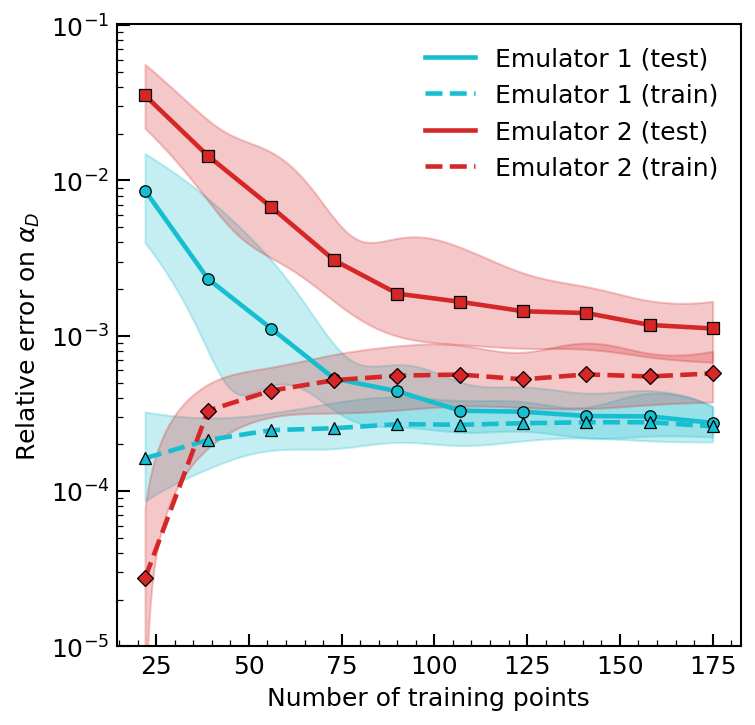

In [97]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ========= User config =========
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
tiers = range(1, 11)
seeds = [123 + i for i in range(100)]

# CSV layout:
# ../dipoles_exp_param/alphaD_eval_{Em1|Em2}_{seed}/alphaD_relerr_{test|train}_tier{i}.csv
root_fmt = "../dipoles_exp_param/alphaD_eval_{em_tag}_{seed}/alphaD_relerr_{sets}_tier{tier}.csv"

# --- emulator brand colors ---
EM1_COLOR = "#17becf"   # Emulator 1
EM2_COLOR = "#d62728"   # Emulator 2

OUT_FIG = "NumberOfTrain.pdf"
# ===============================

# ---- Matplotlib look/feel ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 15,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.major.size": 6,
    "ytick.minor.size": 3,
    "axes.grid": False,
    "grid.alpha": 0.25,
    "xtick.labelsize": 12,      # smaller tick labels
    "ytick.labelsize": 12     # smaller tick labels
})

# ---- Optional smoothing helpers (SciPy if available) ----
try:
    from scipy.signal import savgol_filter
    from scipy.interpolate import CubicSpline
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def _smooth_1d(y, window_frac=0.20, poly=2):
    if not _HAS_SCIPY or len(y) < 5:
        return y
    w = max(5, int(round(window_frac * len(y))))
    if w % 2 == 0:
        w += 1
    w = min(w, len(y) if len(y) % 2 == 1 else len(y) - 1)
    if w < 5 or w <= poly:
        return y
    return savgol_filter(y, window_length=w, polyorder=min(poly, w - 1))

def _interp_dense(x, y, x_dense):
    x = np.asarray(x, float); y = np.asarray(y, float); x_dense = np.asarray(x_dense, float)
    order = np.argsort(x); x_s = x[order]; y_s = y[order]
    if _HAS_SCIPY and len(x_s) >= 4:
        cs = CubicSpline(x_s, y_s, bc_type="natural", extrapolate=False)
        yd = cs(x_dense)
        if np.any(np.isnan(yd)):
            yd_lin = np.interp(x_dense, x_s, y_s)
            yd = np.where(np.isnan(yd), yd_lin, yd)
        return yd
    return np.interp(x_dense, x_s, y_s)

# ---- Data loader for one emulator/setting ----
def collect_seed_curves(em_tag: str, sets: str):
    """Returns per-seed arrays of mean rel_abs per tier. Skips incomplete seeds."""
    per_seed = []
    for seed in seeds:
        ok = True
        vals = []
        for t in tiers:
            csv_path = root_fmt.format(em_tag=em_tag, seed=seed, sets=sets, tier=t)
            if not os.path.exists(csv_path):
                ok = False
                break
            df = pd.read_csv(csv_path)
            vals.append(df["rel_abs"].to_numpy().mean())
        if ok:
            per_seed.append(np.asarray(vals, dtype=float))
    return per_seed

# ---- Plotting helper: smooth 95% band, NON-interpolated central line ----
def plot_emulator_with_band(n_vals, em_tag, sets, color, label,
                            line_style="-", marker="o",
                            dense_points=400, alpha_band=0.25, lw=2.2,
                            draw_seed_traces=True):
    per_seed = collect_seed_curves(em_tag, sets)
    if len(per_seed) == 0:
        print(f"[WARN] No complete seed curves found for {em_tag} / {sets}. Skipping.")
        return np.full(len(n_vals), np.nan), (np.full(len(n_vals), np.nan), np.full(len(n_vals), np.nan))

    per_seed = np.vstack(per_seed)  # (num_seeds, num_tiers)

    # faint seed traces at original grid
#     if draw_seed_traces:
#         for row in per_seed:
#             plt.plot(n_vals, row, "-", color=color, alpha=0.08, lw=1.0, zorder=1)

    # statistics at original grid
    mean = per_seed.mean(axis=0)
    lo95 = np.percentile(per_seed, 2.5, axis=0)
    hi95 = np.percentile(per_seed, 97.5, axis=0)

    # smooth band only (dense x for prettier edges)
    x_dense = np.linspace(min(n_vals), max(n_vals), dense_points)
    lo95_d = _interp_dense(n_vals, lo95, x_dense)
    hi95_d = _interp_dense(n_vals, hi95, x_dense)
    lo95_d = _smooth_1d(lo95_d, window_frac=0.20, poly=2)
    hi95_d = _smooth_1d(hi95_d, window_frac=0.20, poly=2)
    lo95_d = np.minimum(lo95_d, hi95_d)
    hi95_d = np.maximum(hi95_d, lo95_d)
    plt.fill_between(x_dense, lo95_d, hi95_d, color=color, alpha=alpha_band, zorder=2)

    # CENTRAL LINE: plot ONLY on original points (no interpolation)
    plt.plot(n_vals, mean, color=color, linestyle=line_style, lw=lw, label=label, zorder=3)
    plt.plot(n_vals, mean, marker=marker, linestyle="none", color=color,
             mec="black", mew=0.6, markersize=5.5, zorder=4)

    return mean, (lo95, hi95)

# ================== Figure ==================
fig, ax = plt.subplots(figsize=(5.2, 5.0))
ax.set_yscale("log")
ax.set_xlabel("Number of training points", size = 12)
ax.set_ylabel(r"Relative error on $\alpha_D$", size = 12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())


# Emulator 1
plot_emulator_with_band(n, "Em1", "test",  EM1_COLOR, "Emulator 1 (test)",  "-",  "o")
plot_emulator_with_band(n, "Em1", "train", EM1_COLOR, "Emulator 1 (train)", "--", "^")

# Emulator 2
plot_emulator_with_band(n, "Em2", "test",  EM2_COLOR, "Emulator 2 (test)",  "-",  "s")
plot_emulator_with_band(n, "Em2", "train", EM2_COLOR, "Emulator 2 (train)", "--", "D")

ax.legend(frameon=False, loc="upper right", ncol=1)
ax.set_ylim(1e-5, None)

plt.tight_layout()
fig.savefig(OUT_FIG, bbox_inches="tight")
print(f"Saved figure to {OUT_FIG}")
plt.show()


# 